Prediction of House Price Using Neural Networks
Data
The Sacramento real estate transactions file is a list of 985 real estate transactions in the Sacramento area reported over a five-day period, as reported by the Sacramento Bee.

Libraries
These lines import all the necessary libraries. We have pandas and numpy for data manipulation, sklearn's preprocessing tools for standardizing numerical data and encoding categorical data, and model_selection tools for splitting the data and tuning hyperparameters. The MLPRegressor is a neural network model from sklearn, and we're using the mean_squared_error function to evaluate the model's performance. The Pipeline and ColumnTransformer are used for building a compound classifier.

In [67]:
pip install folium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 kB 386.8 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [68]:
import pandas as pd
import numpy as np
import folium
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt

## Load Data

In [69]:
# Read CSV
data = pd.read_csv("/Users/Amanda/Downloads/Sacramento_transactions.csv")

## Explore Data

Perform EDA on this dataset. Use what you have learned so far.

In [70]:
data.shape

(985, 12)

In [71]:
data.head()

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768


In [72]:
data.tail()

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
980,9169 GARLINGTON CT,SACRAMENTO,95829,CA,4,3,2280,Residential,Thu May 15 00:00:00 EDT 2008,232425,38.457679,-121.359620
981,6932 RUSKUT WAY,SACRAMENTO,95823,CA,3,2,1477,Residential,Thu May 15 00:00:00 EDT 2008,234000,38.499893,-121.458890
982,7933 DAFFODIL WAY,CITRUS HEIGHTS,95610,CA,3,2,1216,Residential,Thu May 15 00:00:00 EDT 2008,235000,38.708824,-121.256803
983,8304 RED FOX WAY,ELK GROVE,95758,CA,4,2,1685,Residential,Thu May 15 00:00:00 EDT 2008,235301,38.417000,-121.397424
984,3882 YELLOWSTONE LN,EL DORADO HILLS,95762,CA,3,2,1362,Residential,Thu May 15 00:00:00 EDT 2008,235738,38.655245,-121.075915


In [73]:
data.isnull().sum()

street       0
city         0
zip          0
state        0
beds         0
baths        0
sq__ft       0
type         0
sale_date    0
price        0
latitude     0
longitude    0
dtype: int64

In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   street     985 non-null    object 
 1   city       985 non-null    object 
 2   zip        985 non-null    int64  
 3   state      985 non-null    object 
 4   beds       985 non-null    int64  
 5   baths      985 non-null    int64  
 6   sq__ft     985 non-null    int64  
 7   type       985 non-null    object 
 8   sale_date  985 non-null    object 
 9   price      985 non-null    int64  
 10  latitude   985 non-null    float64
 11  longitude  985 non-null    float64
dtypes: float64(2), int64(5), object(5)
memory usage: 92.5+ KB


In [75]:
data['zip'] = data['zip'].astype(str)

This line converts the data type of 'zip' column to string as zip codes are not numerical but categorical variables that just happen to consist of numbers

In [76]:
data.describe()

,beds,baths,sq__ft,price,latitude,longitude
count,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000
mean,2.911675,1.776650,1314.916751,234144.263959,38.607732,-121.355982
std,1.307932,0.895371,853.048243,138365.839085,0.145433,0.138278
min,0.000000,0.000000,0.000000,1551.000000,38.241514,-121.551704
25%,2.000000,1.000000,952.000000,145000.000000,38.482717,-121.446127
50%,3.000000,2.000000,1304.000000,213750.000000,38.626582,-121.376220
75%,4.000000,2.000000,1718.000000,300000.000000,38.695589,-121.295778
max,8.000000,5.000000,5822.000000,884790.000000,39.020808,-120.597599


In [77]:
data['zip'] = data['zip'].astype(str)

In [78]:
columns_to_replace = ['beds', 'baths', 'sq__ft']
data[columns_to_replace] = data[columns_to_replace].replace(0, 'plot')

In [79]:
data = data[~data.apply(lambda row: row.apply(str).str.contains('plot')).any(axis=1)]

In [80]:
data.shape

(814, 12)

In [81]:
# Specify categorical and numeric columns
categorical_columns = ['zip', 'type', 'city']
numeric_columns = ['beds', 'baths', 'sq__ft']

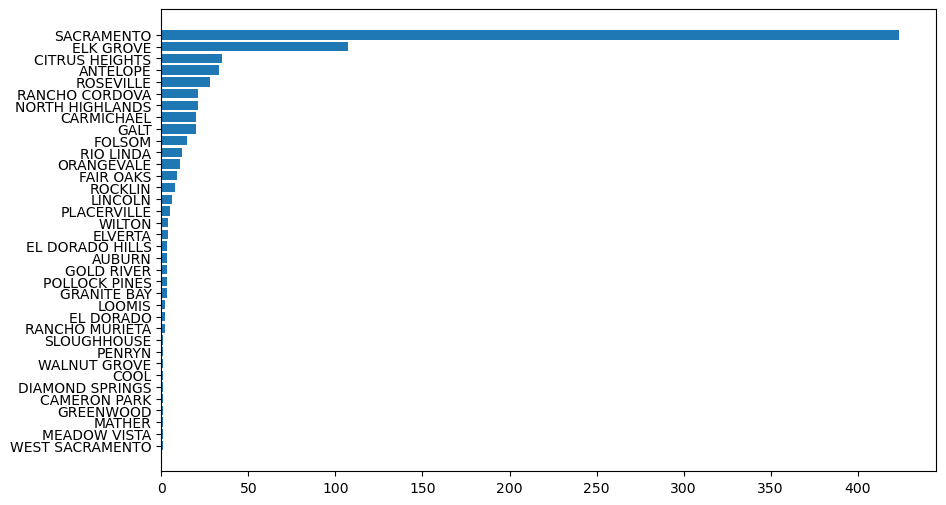

In [82]:
# Count the occurrences of each city
city_counts = data['city'].value_counts()

# Sort the data from high to low counts
city_counts_sorted = city_counts.sort_values(ascending=True)

# Create a horizontal bar graph with a larger figure size
plt.figure(figsize=(10, 6))
plt.barh(city_counts_sorted.index, city_counts_sorted.values)

# Show the graph
plt.show()

In [84]:
# Make an empty map to visualize the location of the properties
# 37.76, -122.45 is the initital location of SF, USA
m = folium.Map(location=[38.575764, -121.478851], tiles="OpenStreetMap", zoom_start=10)

#I can add circle/marker one by one on the map
for i in range(0, len(data.head(1000))):
   folium.Marker(
       location=[data.iloc[i]['latitude'], data.iloc[i]['longitude']]
   ).add_to(m)
    
display(m)

In [85]:
# Specify the preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

In these lines, we're setting up the preprocessing pipelines for both numeric and categorical data. Numeric data is standardized using StandardScaler and categorical data is one-hot encoded using OneHotEncoder. The ColumnTransformer is then used to apply these transformations to the respective columns.

In [86]:
# Define the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('mlp', MLPRegressor(max_iter=500, random_state=42))
])

In [87]:
# Specify a grid for hyperparameter tuning
param_grid = {
    'mlp__hidden_layer_sizes': [(30,30,30), (50,50,50), (50,100,50)],
    'mlp__activation': ['tanh', 'relu'],
    'mlp__solver': ['sgd', 'adam'],
}

This code sets up a grid of hyperparameters to tune the MLPRegressor. This process is known as hyperparameter tuningThe GridSearchCV will try all combinations of these hyperparameters to find the best ones.

In [88]:
# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(model, param_grid, cv=5)

In [89]:
# Separate features and target
X = data[categorical_columns + numeric_columns]
y = data['price']

Here we're creating the feature matrix X and target vector y. X contains the features we want to base our predictions on, and y is the target variable we want to predict (the price).

In [90]:
# Split the data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

This line splits the dataset into training and test sets. 80% of the data will be used for training, and 20% will be used for testing the model.

In [91]:
# Fit the model
grid_search.fit(X_train, y_train)

/Users/Amanda/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Amanda/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Amanda/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Amanda/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Amanda/anaconda3/lib/pyth

/Users/Amanda/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Amanda/anaconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/Amanda/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Amanda/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_base.py:174: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/Amanda/anaconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/Amanda/anaconda3/lib/python3.10/si

/Users/Amanda/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['beds',
                                                                          'baths',
                                                                          'sq__ft']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['zip',
                                                                          'type',
                                                                          'city'])])),
                                       ('mlp',
                                        MLPRegressor(max_iter=500,
                                                     random_state=42))]),
             param_grid={'mlp__activation': ['tanh', 'relu'],
                         'mlp__hidden_layer_sizes': [(30, 30, 30), (50, 50, 50),
                                                     (50, 100, 50)],
                         'mlp__solver': ['sgd', 'adam']})

This line trains the model on the training data. GridSearchCV will automatically find the best hyperparameters from the grid we specified.

In [92]:
# Display the best parameters
print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'mlp__activation': 'relu', 'mlp__hidden_layer_sizes': (50, 100, 50), 'mlp__solver': 'adam'}


This line prints out the best hyperparameters found by GridSearchCV.

In [93]:
# Make predictions
y_pred = grid_search.predict(X_test)

This line uses the trained model to make predictions on the test data.

In [94]:
# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 4936330389.371088


Here we calculate the Mean Squared Error (MSE) of the model's predictions.

In [95]:
# Predict the price for a given house
new_house = pd.DataFrame([["95814", "Residential", "SACRAMENTO", 3, 2, 1204]], columns=categorical_columns + numeric_columns)
predicted_price = grid_search.predict(new_house)
print(f"Predicted price for the new house: {predicted_price[0]}")


Predicted price for the new house: 271064.9510264744


This part of the code predicts the price for a new house given its features.

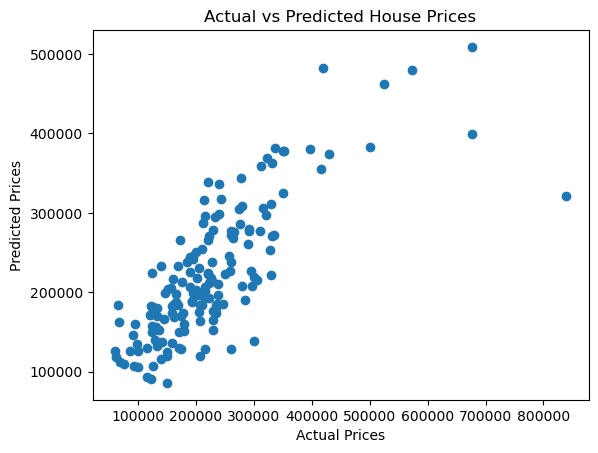

In [96]:
# Plot actual vs predicted
plt.scatter(y_test, y_pred)
# plt.plot(y_test, y_test, color='r')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted House Prices')
plt.show()